# Тестовый инференс обученной сети:

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet18
from  matplotlib import pyplot as plt

# Перемещаем модель на GPU, если она доступна
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=None)
model = model.to(device).eval()

# Извлеките слой "avgpool" для получения фичей перед полносвязанным слоем
model = torch.nn.Sequential(*list(model.children())[:-1])

# Загрузка весов
model.load_state_dict(torch.load('model_weights.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'model_weights.pth'

In [9]:
def plot_images(image_path1, image_path2):
    # Создаем фигуру и оси для subplot
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    # Отображаем изображения на subplot
    axes[0].imshow(plt.imread(image_path1))
    axes[0].set_title('Image 1')
    axes[0].axis('off')

    axes[1].imshow(plt.imread(image_path2))
    axes[1].set_title('Image 2')
    axes[1].axis('off')

In [10]:
def load_and_preprocess_image(image_path):
    # Загрузка изображения и применение преобразований
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image.unsqueeze(0)  # Добавляем размерность пакета

def compute_distance(image1_path, image2_path, model, distance_metric='euclidean'):
    # Загрузка и предобработка изображений
    image1 = load_and_preprocess_image(image1_path)
    image2 = load_and_preprocess_image(image2_path)

    # Перемещаем изображения на устройство
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image1 = image1.to(device)
    image2 = image2.to(device)

    # Прогоняем изображения через модель
    with torch.no_grad():
        output1 = model(image1)
        output2 = model(image2)

    # Вычисляем расстояние между векторами
    if distance_metric == 'euclidean':
        distance = torch.norm(output1 - output2)
    elif distance_metric == 'cosine':
        distance = torch.nn.functional.cosine_similarity(output1, output2)
    else:
        raise ValueError("Неверная метрика расстояния. Допустимые значения: 'euclidean' или 'cosine'.")

    return distance.item()  # Возвращаем расстояние в виде числа


тут 2 одинаковых лица из тестового датасета:

Евклидово расстояние между изображениями: 0.8786250352859497
Косинусное расстояние между изображениями: 0.998755693435669


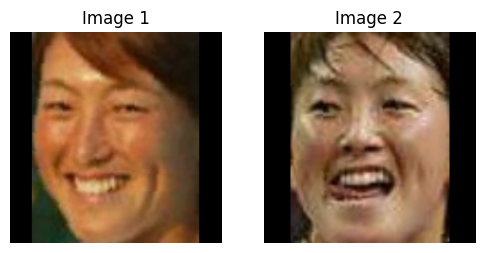

In [11]:
# Пример использования
image1_path = 'LFW_faces_dataset_cropped/Ai_Sugiyama/Ai_Sugiyama_0001.jpg'
image2_path = 'LFW_faces_dataset_cropped/Ai_Sugiyama/Ai_Sugiyama_0005.jpg'
plot_images(image1_path, image2_path)
distance = compute_distance(image1_path, image2_path, model, distance_metric='euclidean')
print(f"Евклидово расстояние между изображениями: {distance}")

distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Косинусное расстояние между изображениями: {distance}")

тут 2 разных лица из тестового датасета:

Евклидово расстояние между изображениями: 2.0737555027008057
Косинусное расстояние между изображениями: 0.993549108505249


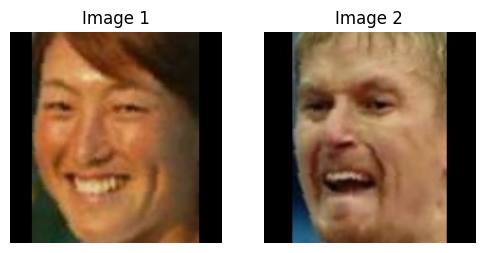

In [12]:
# Пример использования
image1_path = 'LFW_faces_dataset_cropped/Ai_Sugiyama/Ai_Sugiyama_0001.jpg'
image2_path = 'LFW_faces_dataset_cropped/Yevgeny_Kafelnikov/Yevgeny_Kafelnikov_0001.jpg'
plot_images(image1_path, image2_path)
distance = compute_distance(image1_path, image2_path, model, distance_metric='euclidean')
print(f"Евклидово расстояние между изображениями: {distance}")

distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Косинусное расстояние между изображениями: {distance}")

---

### Пример с полным инференсом: Сначала через фейс детектор и лишь потом наша сеть.


In [52]:
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from deepface import DeepFace

def load_and_preprocess_image(image_path):
    # Загрузка изображения и применение преобразований
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image.unsqueeze(0)  # Добавляем размерность пакета

def extract_faces_and_compute_distance(model, image_path1, image_path2, distance_metric='euclidean'):
    # Извлекаем лица из изображений
    face_image1 = DeepFace.extract_faces(image_path1, target_size=(224, 224), detector_backend='yolov8')
    face_image2 = DeepFace.extract_faces(image_path2, target_size=(224, 224), detector_backend='yolov8')
    
    # Преобразуем лица в формат PIL Image и преобразуем к размеру (224, 224)
    face_pil_image1 = Image.fromarray((face_image1[0]['face'] * 255).astype(np.uint8))
    face_pil_image2 = Image.fromarray((face_image2[0]['face'] * 255).astype(np.uint8))

    # Преобразуем лица в тензоры
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    face_tensor1 = preprocess(face_pil_image1).unsqueeze(0)
    face_tensor2 = preprocess(face_pil_image2).unsqueeze(0)

    # Перемещаем изображения на устройство
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    face_tensor1 = face_tensor1.to(device)
    face_tensor2 = face_tensor2.to(device)

    # Прогоняем изображения через модель
    with torch.no_grad():
        output1 = model(face_tensor1)
        output2 = model(face_tensor2)

    # Вычисляем расстояние между векторами
    if distance_metric == 'euclidean':
        distance = torch.norm(output1 - output2)
    elif distance_metric == 'cosine':
        distance = torch.nn.functional.cosine_similarity(output1, output2)
    else:
        raise ValueError("Неверная метрика расстояния. Допустимые значения: 'euclidean' или 'cosine'.")

    return distance.item()  # Возвращаем расстояние в виде числа


Тут 2 разных человека:

Евклидово расстояние между изображениями лиц: 1.9356422424316406
Косинусное расстояние между изображениями: 0.993549108505249


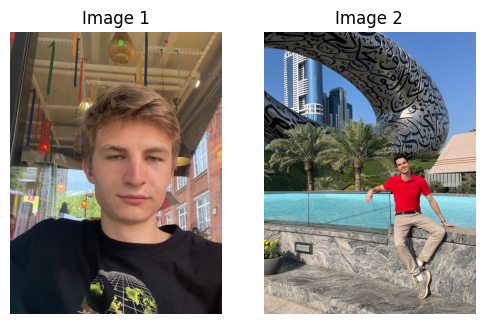

In [56]:
# Пример использования
image_path1 = 'images/1.jpg'
image_path2 = 'images/2.jpg'
plot_images(image_path1, image_path2)
distance = extract_faces_and_compute_distance(model, image_path1, image_path2, distance_metric='euclidean')
print(f"Евклидово расстояние между изображениями лиц: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Косинусное расстояние между изображениями: {distance}")

Тут 2 одинаковых:

Евклидово расстояние между изображениями лиц: 1.2614818811416626
Косинусное расстояние между изображениями: 0.993549108505249


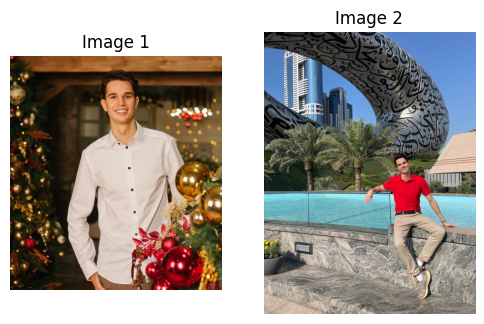

In [55]:
# Пример использования
image_path1 = 'images/3.jpg'
image_path2 = 'images/2.jpg'
plot_images(image_path1, image_path2)
distance = extract_faces_and_compute_distance(model, image_path1, image_path2, distance_metric='euclidean')
print(f"Евклидово расстояние между изображениями лиц: {distance}")
distance = compute_distance(image1_path, image2_path, model, distance_metric='cosine')
print(f"Косинусное расстояние между изображениями: {distance}")

___

___

Воспользуемся готовой библиотекой (deepface) и их моделями для решения той же самой задачи:

{'verified': False,
 'distance': 1.3752849500350304,
 'threshold': 1.17,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'euclidean',
 'facial_areas': {'img1': {'x': 282,
   'y': 329,
   'w': 383,
   'h': 383,
   'left_eye': (127, 151),
   'right_eye': (257, 156)},
  'img2': {'x': 499,
   'y': 481,
   'w': 61,
   'h': 61,
   'left_eye': None,
   'right_eye': None}},
 'time': 1.6}

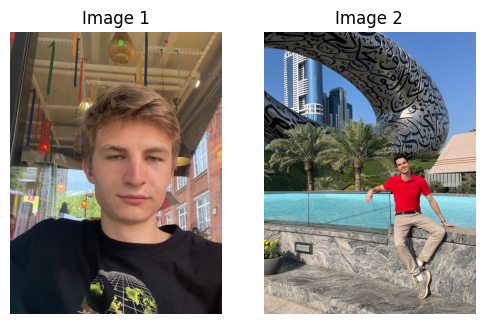

In [37]:
metrics = ["cosine", "euclidean", "euclidean_l2"]

# Пример использования
image_path1 = 'images/1.jpg'
image_path2 = 'images/2.jpg'
plot_images(image_path1, image_path2)

#face verification
result = DeepFace.verify(img1_path = image_path1, 
          img2_path = image_path2, 
          distance_metric = metrics[1]
)
result

{'verified': True,
 'distance': 1.033596225870393,
 'threshold': 1.17,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'euclidean',
 'facial_areas': {'img1': {'x': 419,
   'y': 123,
   'w': 177,
   'h': 177,
   'left_eye': (55, 70),
   'right_eye': (118, 69)},
  'img2': {'x': 499,
   'y': 481,
   'w': 61,
   'h': 61,
   'left_eye': None,
   'right_eye': None}},
 'time': 3.99}

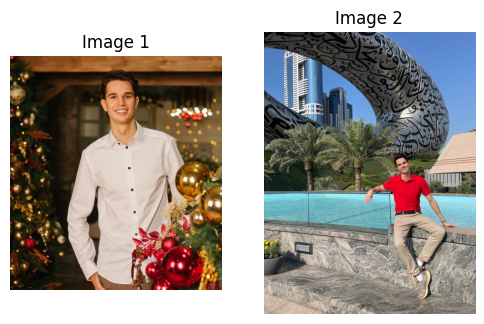

In [36]:
metrics = ["cosine", "euclidean", "euclidean_l2"]

# Пример использования
image_path1 = 'images/3.jpg'
image_path2 = 'images/2.jpg'
plot_images(image_path1, image_path2)

#face verification
result = DeepFace.verify(img1_path = image_path1, 
          img2_path = image_path2, 
          distance_metric = metrics[1]
)
result